# Unicity analysis

Here we do not use the panel data (can then use more data).

sketch of what happens here
- divide the 52 weeks into sequences of w=5 weeks (excluding last 2 weeks)
- w then represents a week of browsing data. We do this to make the data bigger.
- Each sequence then contains a set of machines with browsing history in the each of the w weeks in the sequence
- For each w weeks, compute k-anonymous cohorts.
- Use various k, k=2000, k=1000, k=500 ...what are good k?
- Map each user to their sequence of cohort IDs. Then consider k-anonymous cohort sequences
- For week 1, sequence [c1]
- For week 2, sequence [c1, c2]

...
And so on
- At each week, how many users are in cohort sequences with k=1?
- How does this change when we also add some rough proxy of fingerprinting data, like US state?

Are there other interesting things to measure?
- How does the avg k change?


In [297]:
from datetime import datetime
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import floc

from comscore.data import read_weeks_machines_domains
import prefixLSH

## Preprocessing

Set up the data

### Preprocess demographic data for fingerprinting proxy


##### Create mapping from machine ID to U.S. State

Want to use U.S. State as a weak proxy for fingerprinting

Use demographic data file for machine IDs to create mapping from machine id to U.S. State

In [298]:
from pyzipcode import ZipCodeDatabase
import us


YEAR = 2017
demographics_fpath = '../data/comscore/{year}/demographics.csv'.format(year=YEAR)

def get_state_fips(zipcode, err=False):
    """returns a state FIPS for the state with given zipcide.
    
    if it can't find the zip code, return np.nan if err=False.
    
    parameters
    ----------
    err: boolean. True if function should raise a ValueError if it can't find a zip code. False by default.
    """
    zcdb = ZipCodeDatabase()
    if zipcode not in zcdb:
        if err:
            raise ValueError("Zip code not found")
        else:
            return np.nan
    zipcode = zcdb[zipcode]
    state = us.states.lookup(zipcode.state)
    return state.fips


demo_df = (pd.read_csv(demographics_fpath, dtype={'zip_code': str})
           .replace({99:np.nan}))
rows = len(demo_df)
print('%s rows' % rows)
print('dropping rows we cannot find U.S. State data for')
demo_df = (demo_df
           .dropna(subset=['zip_code'])
           # make sure zips are zip5
           .assign(zip_code=lambda x: x.zip_code.apply(lambda z: '0' + z if len(z) < 5 else z))
           # get state fips code for each zip
           .assign(state_fips=lambda x: x.zip_code.apply(lambda z: get_state_fips(z)))
           .dropna(subset=['state_fips'])
           .assign(state=lambda x: x.state_fips.apply(lambda s: us.states.lookup(s).abbr))
          )
print('%s rows after' % len(demo_df))
print('dropped %s rows' % (rows - len(demo_df)))
demo_df.drop('machine_id', axis=1).head()

93808 rows
dropping rows we cannot find U.S. State data for
92884 rows after
dropped 924 rows


,hoh_most_education,census_region,household_size,hoh_oldest_age,household_income,children,racial_background,connection_speed,country_of_origin,zip_code,state_fips,state
0,NaN,4.0,5.0,8.0,16.0,0.0,1.0,1.0,0.0,98611,53,WA
1,3.0,4.0,3.0,8.0,14.0,0.0,1.0,1.0,0.0,80910,08,CO
2,4.0,1.0,3.0,11.0,16.0,1.0,1.0,1.0,0.0,07076,34,NJ
3,3.0,2.0,1.0,9.0,16.0,0.0,1.0,1.0,0.0,62554,17,IL
5,1.0,4.0,3.0,7.0,12.0,0.0,1.0,1.0,1.0,93436,06,CA


Extract mapping of machine ID to U.S. State 

In [299]:
machine_state_df = demo_df.set_index('machine_id')[['state_fips', 'state']]
machine_state_df.head()

,state_fips,state
machine_id,,
46569906.0,53,WA
70298839.0,08,CO
76984170.0,34,NJ
76991725.0,17,IL
81191519.0,06,CA


## Preprocess browsing history data

In [2]:
weeks_machines_domains_fpath = '../output/weeks_machines_domains.csv'

weeks_machines_domains_df = read_weeks_machines_domains(weeks_machines_domains_fpath)

reading from ../output/weeks_machines_domains.csv...
... read 4877236 rows


#### Preprocessing: Apply simhash to each machine week

simhash can only be applied when there are at least 7 unique domains for the week

otherwise the cohort ID is null

Compute simhash for machine weeks with >= 7 domains or otherwise assign null value

In [5]:
def assign_simhash(row):
    """Returns simhash value when valid otherwise NaN."""
    if row.n_domains < 7:
        return np.nan
    return floc.hashes.sim_hash_string(row.domains)

In [6]:
weeks_machines_domains_df['simhash'] = weeks_machines_domains_df.apply(assign_simhash, axis=1)

In [7]:
weeks_machines_domains_df.head()

,machine_id,week,n_domains,domains,simhash
0,169007206,1,104,"{2dopeboyz.com, offers.com, wordpress.com, ora...",1.585204e+14
1,170331223,1,0,{},NaN
2,170422065,1,20,"{shein.com, refinery29.com, messenger.com, num...",5.322881e+14
3,170911221,1,49,"{8haodangpu.cc, vjav.com, 51luoben.com, bilibi...",7.213568e+14
4,171771316,1,64,"{youtube.com, thingames.com, hudsonsfurniture....",6.710488e+14


Save to file

In [8]:
wmd_simhash_fpath = '../output/wmd_simhash.csv'

In [9]:
print('saving precomputed weeks machines simhash data to %s...' % wmd_simhash_fpath)
weeks_machines_domains_df.to_csv(wmd_simhash_fpath, index=False)

saving precomputed weeks machines simhash data to ../output/wmd_simhash.csv...


script re-entry point

In [300]:
weeks_machines_domains_df = pd.read_csv(wmd_simhash_fpath)
print('read in %s total rows' % len(weeks_machines_domains_df))
weeks_machines_domains_df.drop('domains', axis=1).head()

read in 4877236 total rows


,machine_id,week,n_domains,simhash
0,169007206,1,104,1.585204e+14
1,170331223,1,0,NaN
2,170422065,1,20,5.322881e+14
3,170911221,1,49,7.213568e+14
4,171771316,1,64,6.710488e+14


How many machine weeks with non-null vs null simhash?

domains per week distribution across machines
count        975.0
mean        5002.0
std        60482.0
min            1.0
25%            1.0
50%            2.0
75%           40.0
max      1819210.0
Name: n_domains, dtype: float64


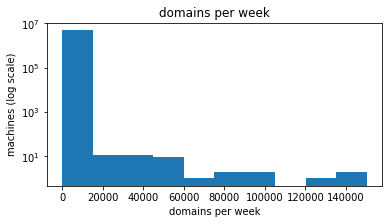

0.43 = 2073405/4877236 machine weeks have >= 7 domains


In [301]:
print('domains per week distribution across machines')
n_domains_value_counts = weeks_machines_domains_df.n_domains.value_counts().sort_index()
print(n_domains_value_counts.describe().round())

fig,ax = plt.subplots(1,1,figsize=(6,3))
ax.hist(weeks_machines_domains_df.n_domains, log=True)
ax.set_title('domains per week')
ax.set_xlabel('domains per week')
ax.set_ylabel('machines (log scale)')
plt.show()

n_domains7 = len(weeks_machines_domains_df[weeks_machines_domains_df.n_domains >= 7])
print('%0.2f = %s/%s machine weeks have >= 7 domains' % (
    n_domains7/len(weeks_machines_domains_df), 
    n_domains7, len(weeks_machines_domains_df))
)

Note all machine IDs occur in all 52 weeks of data.

In [302]:
machine_week_count = weeks_machines_domains_df.groupby('machine_id')['week'].count()
print('\nvalue counts for weeks per machine:')
print(machine_week_count.value_counts())


value counts for weeks per machine:
52    93793
Name: week, dtype: int64


Limit data to machine, weeks with sufficient data for cohort generation: >= 7 domains

In [303]:
n_domains_threshold = 7
print('dropping machine weeks with < %s domains' % n_domains_threshold)
s_before = len(weeks_machines_domains_df)
wmd7_df = weeks_machines_domains_df[weeks_machines_domains_df.n_domains >= n_domains_threshold]
s_after = len(wmd7_df)
print('dropped %s = %s - %s data rows' % ((s_before - s_after), s_before, s_after))

dropping machine weeks with < 7 domains
dropped 2803831 = 4877236 - 2073405 data rows


In [304]:
wmd7_df.drop('machine_id', axis=1).head()

,week,n_domains,domains,simhash
0,1,104,"{'2dopeboyz.com', 'offers.com', 'wordpress.com...",1.585204e+14
2,1,20,"{'shein.com', 'refinery29.com', 'messenger.com...",5.322881e+14
3,1,49,"{'8haodangpu.cc', 'vjav.com', '51luoben.com', ...",7.213568e+14
4,1,64,"{'youtube.com', 'thingames.com', 'hudsonsfurni...",6.710488e+14
5,1,74,"{'cricclubs.com', 'geico.com', 'vanguard.com',...",9.066352e+14


## Preprocessing: Fold / expand data into 5-week sequences

We have browsing data representing 52 weeks for our observed machines. Fold this to represent 5 weeks of browsing for *morem achines* by counting machine browsing weeks as new independent samples every 5 weeks.


Divide the 52 weeks into 5 week sequences, noted by column s, and where each week within a sequence is noted by w.

(0-indexed)


`s = (week - 1) // 5`

i.e. weeks {1,2,3,4,5} in s=0, weeks {6,7,8,9,10} in s=1, ...

each week in a sequence is represented by `w`

where `w = (week - 1) % 5`

i.e. week 1: w=0, week 2: w=1, ..., week 5: w=4, week 6: w=1, week 7: w=2, ...

Then have rows that represent weeks of machine data, where a single machine will have data for multiple w weeks.

We create another column that names machines prefixed by their sequence.

`s_machine_id` which literally concatenates `s` + `_` + `machine_id`


Drop last 2 weeks of data (weeks 51, 52) since they are remainder weeks.

In [305]:
# create new df for folded 5 week sequences data
# drop last 2 weeks of data
print('%s rows of data for %s weeks' % (len(wmd7_df), wmd7_df.week.nunique()))
print('dropping data for weeks 51, 52')
wmd_5s_df = wmd7_df[wmd7_df.week <= 50].copy()
print('%s rows of data for %s weeks' % (len(wmd_5s_df), wmd_5s_df.week.nunique()))

2073405 rows of data for 52 weeks
dropping data for weeks 51, 52
2001191 rows of data for 50 weeks


In [306]:
wmd_5s_df['s'] = wmd_5s_df.week.apply(lambda w: (w - 1) // 5)
wmd_5s_df['w'] = wmd_5s_df.week.apply(lambda w: (w - 1) % 5)
wmd_5s_df['s_machine_id'] = wmd_5s_df[['machine_id','s']].astype(str).apply(lambda x: ('%s_%s'%(x.s, x.machine_id)), axis=1)

In [307]:
wmd_5s_df

,machine_id,week,n_domains,domains,simhash,s,w,s_machine_id
0,169007206,1,104,"{'2dopeboyz.com', 'offers.com', 'wordpress.com...",1.585204e+14,0,0,0_169007206
2,170422065,1,20,"{'shein.com', 'refinery29.com', 'messenger.com...",5.322881e+14,0,0,0_170422065
3,170911221,1,49,"{'8haodangpu.cc', 'vjav.com', '51luoben.com', ...",7.213568e+14,0,0,0_170911221
4,171771316,1,64,"{'youtube.com', 'thingames.com', 'hudsonsfurni...",6.710488e+14,0,0,0_171771316
5,176278357,1,74,"{'cricclubs.com', 'geico.com', 'vanguard.com',...",9.066352e+14,0,0,0_176278357
...,...,...,...,...,...,...,...,...
4688726,218777517,50,9,"{'livejasmin.com', 'edmunds.com', 'surveys-xvi...",9.764213e+14,9,4,9_218777517
4688751,184175562,50,8,"{'driversupport.com', 'microsoft.com', 'cassio...",8.962970e+14,9,4,9_184175562
4688886,204379062,50,7,"{'giftcardmall.com', 'cigarsinternational.com'...",4.523934e+13,9,4,9_204379062
4688934,216873446,50,7,"{'youtube.com', 'meiqia.com', 'google.com', 'v...",4.506417e+14,9,4,9_216873446


Limit to machines (`s_machine_id`s) that have data across all weeks (`w`) in a sequence.


value counts for weeks per s_machine_id:
5    215625
1    122891
4     91887
2     91479
3     83223
Name: w, dtype: int64


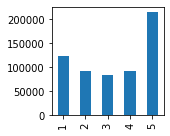

In [308]:
s_machine_w_count = wmd_5s_df.groupby('s_machine_id')['w'].count()
print('\nvalue counts for weeks per s_machine_id:')
print(s_machine_w_count.value_counts())
fig,ax = plt.subplots(1,1,figsize=(2,2))
_ = s_machine_w_count.value_counts().sort_index().plot.bar(ax=ax)

In [309]:
m_before = wmd_5s_df.machine_id.nunique()
wmd_5s_df.drop(
    wmd_5s_df[(wmd_5s_df.s_machine_id.map(s_machine_w_count) < 5)].index,
    inplace=True
)
m_after = wmd_5s_df.machine_id.nunique()
print('%s s_machine_id\'s after dropping those lacking data across all 5 w in a sequence (%s before)' % (
    m_after, m_before))

45738 s_machine_id's after dropping those lacking data across all 5 w in a sequence (87197 before)


Compute cohorts for each w

Trying a range of k values
- k=200
- k=2000

OR diminishing by powers of 2?
- k=2000
- k=1000
- k=500
- k=250
- k=125

In [313]:
cohort_ks = [2000,1000,500,250,125, 200]
# column names for cohort assignments for given k
# e.g. cohort_k2000 = 'cohort_k2000'
cohort_k_columns = ['cohort_k%s'%k for k in cohort_ks]

cohort_k_column_zip = zip(cohort_ks, cohort_k_columns)

# assign cohorts for each w
for (k, c) in cohort_k_column_zip:
    print('computing cohorts for k=%s (column name %s)' % (k,c))
    wmd_5s_df[c] = np.nan
    for w in wmd_5s_df.w.unique():
        t_start = datetime.now()
        print('w %s' % (w))
        w_df = wmd_5s_df[(wmd_5s_df.w==w)]
        cohorts_dict = prefixLSH.get_cohorts_dict(w_df.simhash.astype(int), min_k=k)
        assign_cohort = lambda x: cohorts_dict[x.simhash] if x.w == w else x[c]
        wmd_5s_df[c] = wmd_5s_df.apply(assign_cohort, axis=1)
        print('took %s' % (datetime.now() - t_start))

computing cohorts for k=2000 (column name cohort_k2000)
w 0
took 0:00:19.768718
w 1
took 0:00:20.666343
w 2
took 0:00:19.561003
w 3
took 0:00:18.968154
w 4
took 0:00:18.595705
computing cohorts for k=1000 (column name cohort_k1000)
w 0
took 0:00:20.115495
w 1
took 0:00:18.512794
w 2
took 0:00:18.421723
w 3
took 0:00:17.915201
w 4
took 0:00:19.357381
computing cohorts for k=500 (column name cohort_k500)
w 0
took 0:00:19.117108
w 1
took 0:00:19.748024
w 2
took 0:00:19.056213
w 3
took 0:00:19.408267
w 4
took 0:00:19.007598
computing cohorts for k=250 (column name cohort_k250)
w 0
took 0:00:20.456154
w 1
took 0:00:21.240234
w 2
took 0:00:19.777793
w 3
took 0:00:19.094063
w 4
took 0:00:19.197990
computing cohorts for k=125 (column name cohort_k125)
w 0
took 0:00:20.925066
w 1
took 0:00:21.256284
w 2
took 0:00:21.024885
w 3
took 0:00:20.237280
w 4
took 0:00:20.884966
computing cohorts for k=200 (column name cohort_k200)
w 0
took 0:00:20.653841
w 1
took 0:00:19.930801
w 2
took 0:00:20.327437


How many total cohorts? How many in each cohort? (For a given week)

for k=2000


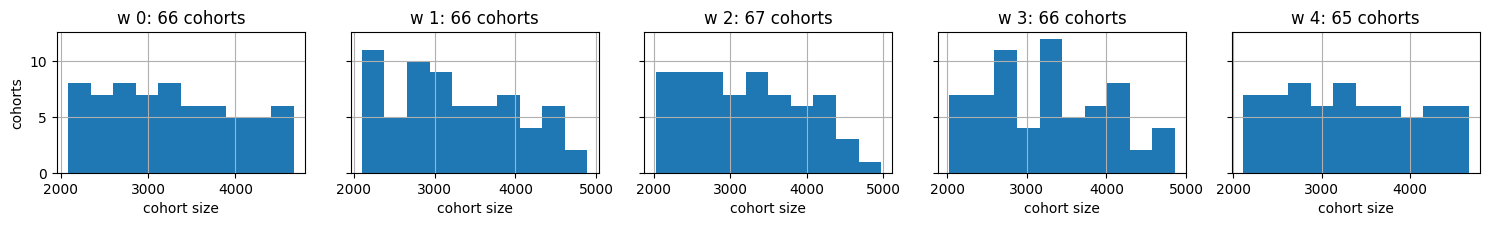

for k=1000


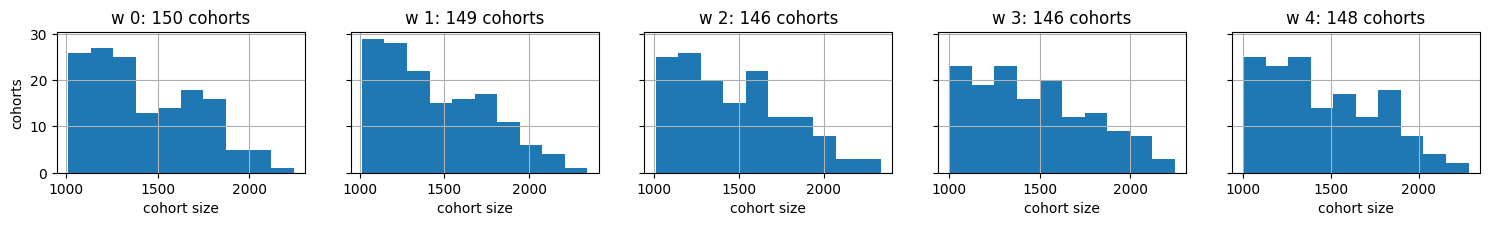

for k=500


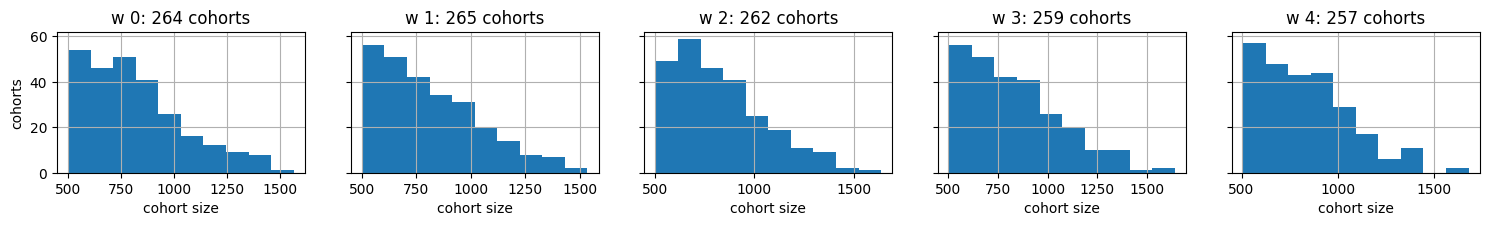

for k=250


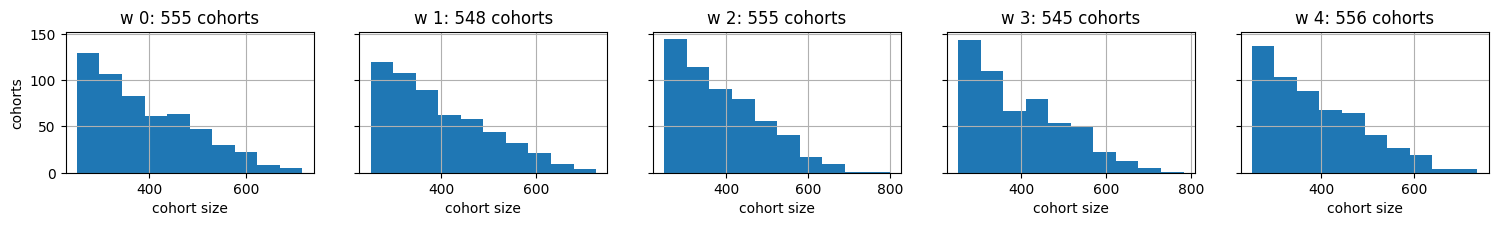

for k=125


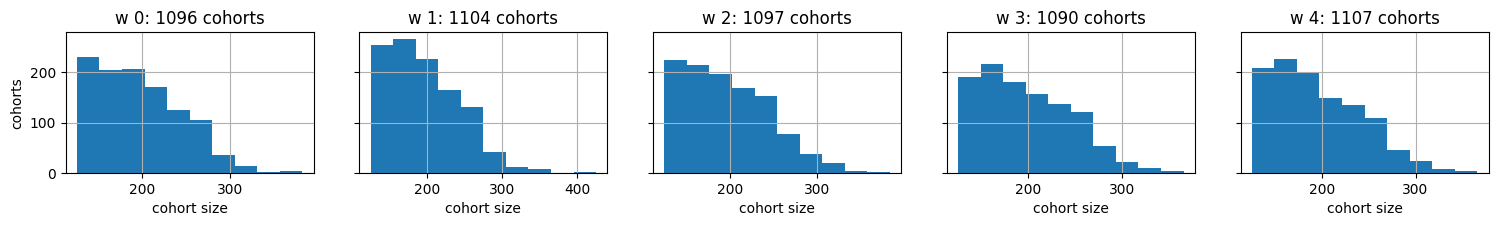

for k=200


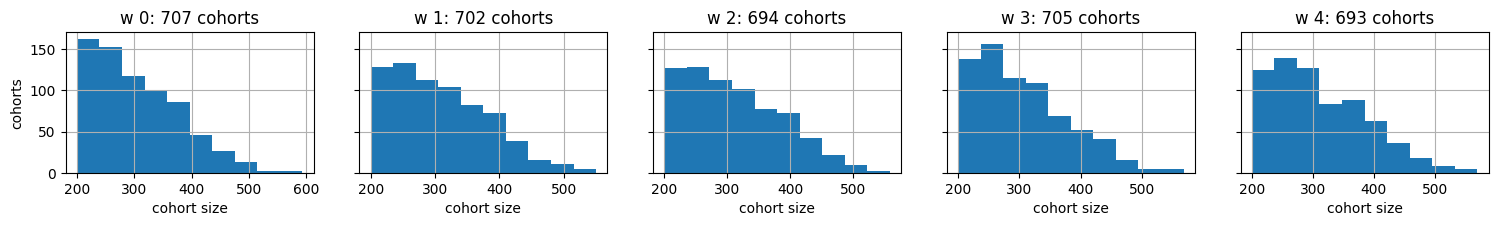

In [314]:
for (k, c) in zip(cohort_ks, cohort_k_columns):
    print('for k=%s'%k)
    fig, axes = plt.subplots(1, 5, figsize=(5*3, 2), sharey=True, dpi=100)
    plt.tight_layout()
    for i, w in enumerate(range(5)):
        ax = axes[i]
        wmd_5s_df[wmd_5s_df.w == w][c].value_counts().hist(ax=ax)
        ax.set_title('w %s: %s cohorts' % (w, wmd_5s_df[wmd_5s_df.w == w][c].nunique()))
        ax.set_xlabel("cohort size")
    _ = axes[0].set_ylabel("cohorts")
    plt.show()

In [315]:
wmd_5s_df.head()

,machine_id,week,n_domains,domains,simhash,s,w,s_machine_id,cohort_k2000,cohort_k1000,cohort_k500,cohort_k250,cohort_k125,cohort_k200
0,169007206,1,104,"{'2dopeboyz.com', 'offers.com', 'wordpress.com...",1.585204e+14,0,0,0_169007206,9.0,20.0,33.0,69.0,143.0,94.0
2,170422065,1,20,"{'shein.com', 'refinery29.com', 'messenger.com...",5.322881e+14,0,0,0_170422065,27.0,63.0,108.0,219.0,461.0,289.0
3,170911221,1,49,"{'8haodangpu.cc', 'vjav.com', '51luoben.com', ...",7.213568e+14,0,0,0_170911221,40.0,90.0,158.0,322.0,658.0,415.0
4,171771316,1,64,"{'youtube.com', 'thingames.com', 'hudsonsfurni...",6.710488e+14,0,0,0_171771316,36.0,82.0,142.0,289.0,597.0,377.0
5,176278357,1,74,"{'cricclubs.com', 'geico.com', 'vanguard.com',...",9.066352e+14,0,0,0_176278357,52.0,119.0,208.0,439.0,878.0,558.0


Make table

weekly s_machine_id cohorts `w_smid_cohorts_5s`

```
s_machine_id, state, w0_cohortkK, ...,  w4_cohortkK
```

where 
- each w1_cohortkK corresponds to the cohort assignment for w:1 for k=K for that s_machine_id. etc
- state is the u.s. state for the machine with s_machine_id


make table for uniqueness of cohort assignments `w_unicity_5s`

```
w, cohortkK, state_cohortkK
```

where
- cohortkK is the fraction of s_machine_id's that have unique sequences by week w using cohorts assigned with k=K
- state_cohortkK is the fraction of s_machine_id's that have unique sequences by week w using cohorts assigned with k=K and combining sequence and state (fingerprinting) data

In [368]:
s_machine_to_state = wmd_5s_df.set_index('s_machine_id').drop_duplicates(subset=['machine_id'])['machine_id'].map(machine_state_df['state']).sort_index()
s_machine_to_state.head()

s_machine_id
0_100607252     TX
0_113363130     IL
0_120603212     WI
0_122998696    NaN
0_124374318     OK
Name: machine_id, dtype: object

In [371]:
wmd_5s_df = wmd_5s_df.set_index('s_machine_id').sort_index()
w_smid_cohorts_5s_df = pd.DataFrame({
    's_machine_id': sorted(wmd_5s_df.index.unique()),
}).set_index('s_machine_id')
w_smid_cohorts_5s_df['state'] = w_smid_cohorts_5s_df.index.map(s_machine_to_state)
for c in cohort_k_columns:
    for w in range(5):
        w_smid_cohorts_5s_df['w%s_%s'%(w, c)] = wmd_5s_df[wmd_5s_df.w==w][c].astype(int)
w_smid_cohorts_5s_df.head(8)

,state,w0_cohort_k2000,w1_cohort_k2000,w2_cohort_k2000,w3_cohort_k2000,w4_cohort_k2000,w0_cohort_k1000,w1_cohort_k1000,w2_cohort_k1000,w3_cohort_k1000,...,w0_cohort_k125,w1_cohort_k125,w2_cohort_k125,w3_cohort_k125,w4_cohort_k125,w0_cohort_k200,w1_cohort_k200,w2_cohort_k200,w3_cohort_k200,w4_cohort_k200
s_machine_id,,,,,,,,,,,,,,,,,,,,,
0_100607252,TX,20,35,16,21,45,46,78,36,47,...,332,593,260,357,764,212,368,170,226,474
0_113363130,IL,20,6,6,27,18,46,14,14,61,...,331,98,98,464,307,212,61,62,293,188
0_120603212,WI,17,29,56,48,50,40,65,122,107,...,283,498,916,808,860,181,305,579,516,533
0_122998696,NaN,18,44,36,29,5,41,100,80,65,...,288,747,600,493,76,186,467,379,310,45
0_124374318,OK,14,54,27,32,52,33,123,60,71,...,238,916,461,539,894,153,575,286,341,554
0_125424162,VA,6,43,44,39,25,15,96,94,85,...,105,719,707,640,429,72,446,446,408,259
0_127266303,ME,25,41,34,22,8,60,93,75,48,...,428,697,568,362,124,274,431,358,230,74
0_129586098,CO,18,15,66,25,5,42,34,144,57,...,300,249,1070,419,82,194,154,679,269,48


Note: It should not be surprising that cohort IDs are not repeated across weeks because the cohorts are computed separately for each week, and therefore have different semantic meaning each week.

In [405]:
# note the total number is different for sequences using state because some
# machines have NaN state and are excluded from this computation
total = len(w_smid_cohorts_5s_df)
state_total = len(w_smid_cohorts_5s_df.dropna())
print('%s = total: total number of smids summed across all cohorts' % total)
print('%s = state_total: total number of smids summed across all cohorts that also have state data' % state_total)


w_unicity_5s_df = pd.DataFrame({'w':range(5)}).set_index('w')

for c in cohort_k_columns:
    c_w_sizes = []
    c_state_w_sizes = []
    for w in range(5):
        w_cols = ['w%s_%s' % (wi, c) for wi in range(w+1)]
        state_w_cols = ['state'] + ['w%s_%s' % (wi, c) for wi in range(w+1)]
        #print(state_w_cols)
        # in the firat week, all cohort sequences are size >= k
        cohort_w_seq_sizes = w_smid_cohorts_5s_df.groupby(w_cols).size().values
        cohort_state_w_seq_sizes = w_smid_cohorts_5s_df.groupby(state_w_cols).size().values
        # how many are size 1?
        cohort_w_seq_unique = sum(cohort_w_seq_sizes == 1)
        cohort_state_w_seq_unique = sum(cohort_state_w_seq_sizes == 1)
        # sanity check: totals / denominators should always be the same size
        assert(total==cohort_w_seq_sizes.sum())
        assert(state_total==cohort_state_w_seq_sizes.sum())
        c_w_sizes += [cohort_w_seq_unique/total]
        c_state_w_sizes += [cohort_state_w_seq_unique/state_total]
    w_unicity_5s_df[c] = c_w_sizes
    w_unicity_5s_df['state_%s'%c] = c_state_w_sizes
w_unicity_5s_df

215625 = total: total number of smids summed across all cohorts
45408 = state_total: total number of smids summed across all cohorts that also have state data


,cohort_k2000,state_cohort_k2000,cohort_k1000,state_cohort_k1000,cohort_k500,state_cohort_k500,cohort_k250,state_cohort_k250,cohort_k125,state_cohort_k125,cohort_k200,state_cohort_k200
w,,,,,,,,,,,,
0,0.000000,0.006320,0.000000,0.024797,0.000000,0.058250,0.000000,0.150194,0.000000,0.290015,0.000000,0.195208
1,0.000000,0.616587,0.002310,0.891429,0.064431,0.958554,0.410611,0.991235,0.766998,0.997710,0.558085,0.994296
2,0.369711,0.985399,0.865823,0.998282,0.965519,0.999736,0.995066,0.999956,0.999193,1.000000,0.997510,0.999956
3,0.954704,0.999516,0.996851,1.000000,0.999397,1.000000,0.999930,1.000000,0.999958,1.000000,0.999958,1.000000
4,0.997542,1.000000,0.999879,1.000000,0.999968,1.000000,0.999981,1.000000,0.999981,1.000000,0.999981,1.000000


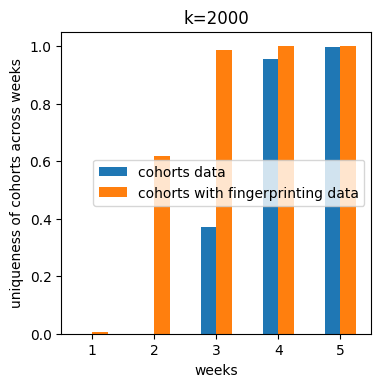

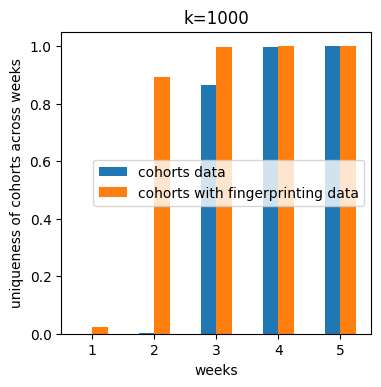

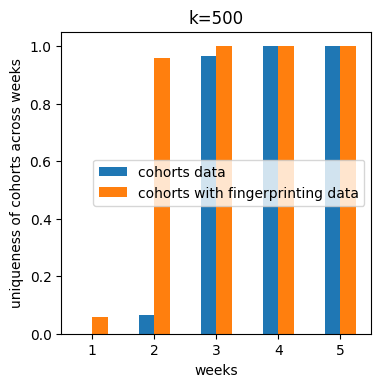

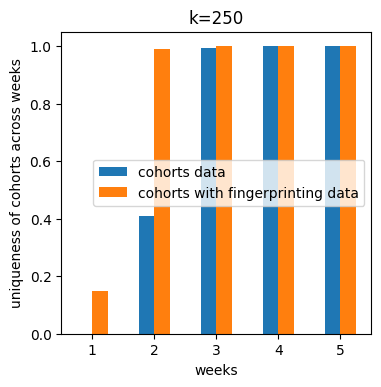

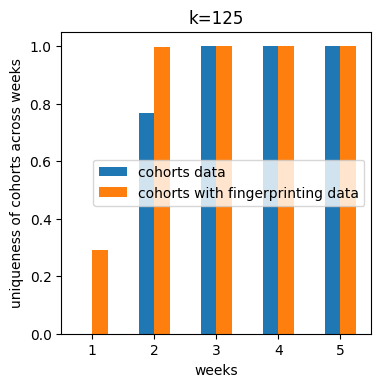

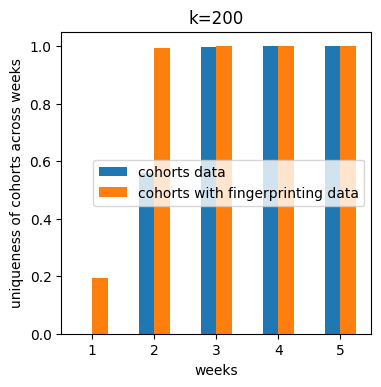

In [433]:
for (k,c) in cohort_k_column_zip:
    fig,ax = plt.subplots(1,1,figsize=(4,4),dpi=100)
    w_unicity_5s_df.reset_index().plot(
        x='w',
        y=[c, 'state_%s'%c],
        kind='bar',
        ax=ax,
    )
    ax.set_title('k=%s'%k)
    ax.set_ylabel('uniqueness of cohorts across weeks')
    ax.set_xlabel('weeks')
    ax.set_xticklabels([1,2,3,4,5], rotation=0)
    _ = ax.legend(['cohorts data','cohorts with fingerprinting data'], loc='center right')

It makes sense that smaller k has worse privacy implications because there are more cohorts when k is smaller. Therefore, from week to week, there are more potential cohorts for a machine to belong to.